# Depression Detection from Text using NLP and Deep Learning

## Project Overview

This notebook demonstrates a comprehensive text-based depression detection system using Natural Language Processing (NLP) and deep learning techniques. The project analyzes textual content to classify mental health states into normal and depression categories.

## Key Features

- **Advanced Text Preprocessing**: Tokenization, stopword removal, and lemmatization
- **Sentence Transformers**: State-of-the-art embeddings using 'all-mpnet-base-v2' model
- **Feature Engineering**: Mean and max pooling of sentence embeddings
- **Class Imbalance Handling**: SMOTE (Borderline) for data augmentation
- **Deep Neural Network**: Regularized architecture with dropout and callbacks
- **Comprehensive Evaluation**: Classification metrics, ROC-AUC analysis
- **Real-time Inference**: Text classification pipeline for new sentences

## Dataset
The dataset is generated using chatGPT

The dataset contains textual paragraphs labeled as:
- **Normal**: Regular, non-depressive text content
- **Depression**: Text indicating depressive symptoms or states

## Methodology

1. **Text Preprocessing**: Clean and normalize text data
2. **Embedding Generation**: Transform text to dense vector representations
3. **Feature Engineering**: Combine mean and max pooled embeddings
4. **Data Balancing**: Apply SMOTE to handle class imbalance
5. **Model Training**: Deep neural network with regularization
6. **Evaluation**: Performance assessment and visualization
7. **Inference**: Real-time classification of new text samples

## Technical Stack

- **NLP**: NLTK, Sentence Transformers
- **Machine Learning**: TensorFlow/Keras, Scikit-learn
- **Data Processing**: Pandas, NumPy
- **Visualization**: Matplotlib, Seaborn
- **Imbalanced Learning**: imbalanced-learn (SMOTE)

## 1. Import Required Libraries

Import all necessary libraries for natural language processing, machine learning, and data visualization.

In [3]:
# Data Processing and Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Natural Language Processing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer

# Machine Learning and Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt

# Download required NLTK data
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
print("NLTK data download completed.")

NLTK data download completed.


## 2. Data Loading and Initial Exploration

Load the depression detection dataset and perform initial data exploration.

In [4]:
# Load the depression detection dataset
# Update this path to match your dataset location
file_path = r"C:\Users\vip\GP-Trails\Final NoteBooks\depression_dataset.csv" 

file = pd.read_csv(file_path)

# Shuffle the dataset to ensure random distribution
file = file.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset loaded successfully!")
print(f"Total samples: {len(file)}")
print(f"Columns: {list(file.columns)}")

Dataset loaded successfully!
Total samples: 10000
Columns: ['paragraph', 'label']


In [5]:
# Display first few rows of the dataset to understand structure
file.head()

,paragraph,label
0,"Lately, I feel like everything is just too muc...",1
1,Every day feels like a struggle. I force mysel...,1
2,Today was a regular day at work. I woke up ear...,0
3,"Lately, I feel like everything is just too muc...",1
4,Today was a regular day at work. I woke up ear...,0


In [6]:
# Extract text and labels from the dataset
text = file['paragraph'].values
label = file['label'].values

print(f"Text samples: {len(text)}")
print(f"Labels: {len(label)}")
print(f"Unique labels: {np.unique(label)}")

Text samples: 10000
Labels: 10000
Unique labels: [0 1]


## 3. Text Preprocessing and Feature Extraction

### 3.1 Initialize NLP Components

Set up the sentence transformer model and NLP preprocessing tools.

In [7]:
# Initialize Sentence Transformer model for text embeddings
# Using 'all-mpnet-base-v2' - high performance model for semantic similarity
print("Loading Sentence Transformer model...")
model_sent = SentenceTransformer('all-mpnet-base-v2')
print("Model loaded successfully!")

Loading Sentence Transformer model...
Model loaded successfully!


In [8]:
# Initialize NLP preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

print(f"Stopwords loaded: {len(stop_words)} words")
print("Lemmatizer initialized")

Stopwords loaded: 198 words
Lemmatizer initialized


### 3.2 Text Preprocessing Pipeline

Clean and preprocess the text data by removing stopwords, lemmatizing, and filtering tokens.

In [9]:
# Preprocess all text data: tokenize, lemmatize, and remove stopwords
texts = []
for i, text in enumerate(file['paragraph']):
    # Tokenize text to lowercase words
    tokens = word_tokenize(text.lower())
    
    # Filter tokens: keep only alphabetic words, remove stopwords, and lemmatize
    filtered_tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word.isalpha() and word not in stop_words
    ]
    
    # Join filtered tokens back into text
    texts.append(' '.join(filtered_tokens))
    
    # Progress indicator for large datasets
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1} texts...")

print(f"Text preprocessing completed. Total texts: {len(texts)}")

Processed 1000 texts...
Processed 2000 texts...
Processed 3000 texts...
Processed 4000 texts...
Processed 5000 texts...
Processed 6000 texts...
Processed 7000 texts...
Processed 8000 texts...
Processed 9000 texts...
Processed 10000 texts...
Text preprocessing completed. Total texts: 10000


In [10]:
texts[0:5]  # Display the first 5 preprocessed texts

['lately feel like everything much wake exhausted unmotivated even simplest task feel overwhelming often avoid friend family want talk care energy try smile fake thought often dark heavy night hardest filled overthinking regret ca remember last time felt genuinely happy sometimes wonder ever end day blur together trying survive',
 'every day feel like struggle force bed see point go motion work disconnected stopped enjoying thing used love appetite gone lost weight people say seem distant right cry without reason constantly tired even sleeping hour avoid conversation isolate feel like carrying weight chest want break thought miss old',
 'today regular day work woke early made breakfast got ready listened music commute office meeting managed complete big task lunch coworker laughed something silly work went gym hour felt really productive evening cooked pasta watched movie cat jumped couch curled beside peaceful end day feel grateful small thing',
 'lately feel like everything much wake

### 3.3 Feature Extraction using Sentence Embeddings

Convert preprocessed text into dense vector representations using Sentence Transformers.

In [11]:
# Generate sentence embeddings with mean and max pooling
print("Generating sentence embeddings...")
text_embeddings = []

for i, text in enumerate(texts):
    # Split text into sentences for better semantic understanding
    sentences = sent_tokenize(text)
    
    # Generate embeddings for each sentence
    embeddings = model_sent.encode(sentences)
    
    # Apply pooling strategies to combine sentence embeddings
    embeddings_mean = np.mean(embeddings, axis=0)  # Average pooling
    embeddings_max = np.max(embeddings, axis=0)    # Max pooling
    
    # Concatenate mean and max embeddings for richer representation
    combined_embeddings = np.concatenate((embeddings_mean, embeddings_max))
    text_embeddings.append(combined_embeddings)
    
    # Progress indicator
    if (i + 1) % 500 == 0:
        print(f"Processed {i + 1}/{len(texts)} texts...")

print(f"Feature extraction completed. Generated {len(text_embeddings)} embeddings.")

Generating sentence embeddings...
Processed 500/10000 texts...
Processed 1000/10000 texts...
Processed 1500/10000 texts...
Processed 2000/10000 texts...
Processed 2500/10000 texts...
Processed 3000/10000 texts...
Processed 3500/10000 texts...
Processed 4000/10000 texts...
Processed 4500/10000 texts...
Processed 5000/10000 texts...
Processed 5500/10000 texts...
Processed 6000/10000 texts...
Processed 6500/10000 texts...
Processed 7000/10000 texts...
Processed 7500/10000 texts...
Processed 8000/10000 texts...
Processed 8500/10000 texts...
Processed 9000/10000 texts...
Processed 9500/10000 texts...
Processed 10000/10000 texts...
Feature extraction completed. Generated 10000 embeddings.


In [12]:
text_embeddings = np.array(text_embeddings)
# Verify embedding array structure
print(f"Embeddings array shape: {text_embeddings.shape}")
print(f"Data type: {text_embeddings.dtype}")
print(f"Memory usage: {text_embeddings.nbytes / 1024 / 1024:.2f} MB")

Embeddings array shape: (10000, 1536)
Data type: float32
Memory usage: 58.59 MB


In [13]:
# Assign features (X) and labels (y) for machine learning
x = text_embeddings
y = label

print(f"Features shape: {x.shape}")
print(f"Labels shape: {y.shape}")
print(f"Feature-label alignment check: {len(x) == len(y)}")

Features shape: (10000, 1536)
Labels shape: (10000,)
Feature-label alignment check: True


## 4. Data Analysis and Class Imbalance Handling

### 4.1 Exploratory Data Analysis

Analyze the distribution of classes in our dataset.

Counter({1: 5000, 0: 5000})
=== Dataset Class Distribution ===
Class distribution: {1: 5000, 0: 5000}
Class imbalance ratio: 1.00:1


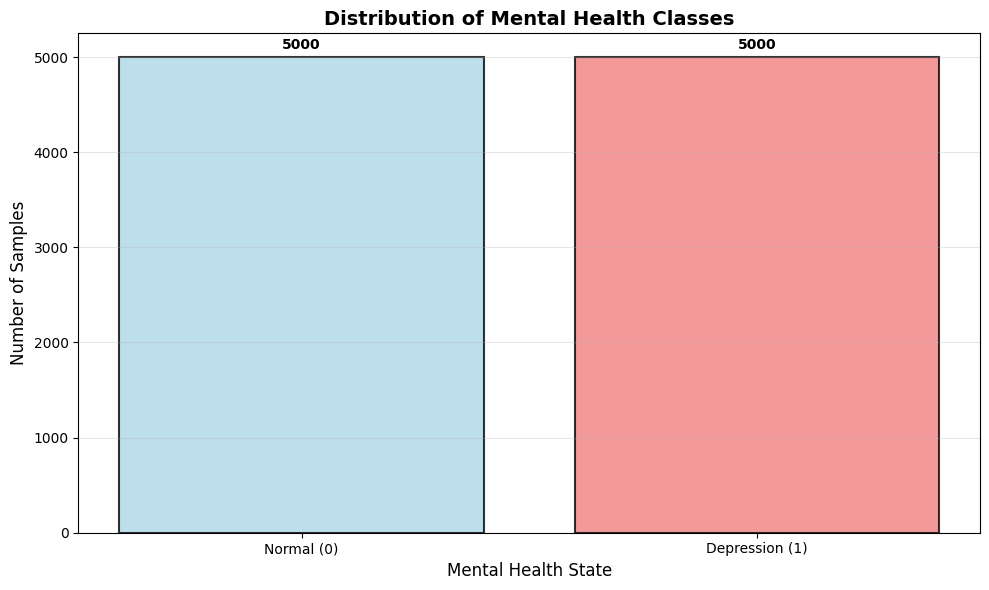


Total samples: 10000


In [14]:
print(Counter(y))

# Analyze class distribution
class_counts = Counter(y)
print("=== Dataset Class Distribution ===")
print(f"Class distribution: {dict(class_counts)}")

# Calculate class imbalance ratio
classes = list(class_counts.keys())
if len(classes) == 2:
    ratio = max(class_counts.values()) / min(class_counts.values())
    print(f"Class imbalance ratio: {ratio:.2f}:1")

# Visualize class distribution
plt.figure(figsize=(10, 6))
labels = ['Normal (0)', 'Depression (1)']
colors = ['lightblue', 'lightcoral']

plt.bar(labels, [class_counts[0], class_counts[1]], 
        color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.xlabel('Mental Health State', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Distribution of Mental Health Classes', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate([class_counts[0], class_counts[1]]):
    plt.text(i, v + max(class_counts.values()) * 0.01, str(v), 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal samples: {sum(class_counts.values())}")

## 5. Data Preparation for Machine Learning

### 5.1 Train-Test Split and Data Shuffling

Prepare the data for training by splitting and shuffling.

In [15]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80-20 split)
# Use stratification to maintain class balance in both sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("=== Train-Test Split Results ===")
print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"Training class distribution: {Counter(y_train)}")
print(f"Testing class distribution: {Counter(y_test)}")

# Verify shapes
print(f"\nFeature shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

=== Train-Test Split Results ===
Training set: 8000 samples
Testing set: 2000 samples
Training class distribution: Counter({0: 4000, 1: 4000})
Testing class distribution: Counter({0: 1000, 1: 1000})

Feature shapes:
X_train: (8000, 1536)
X_test: (2000, 1536)


## 6. Deep Learning Model Implementation

### 6.1 Text Preprocessing Function

Define the preprocessing function for consistent text cleaning during inference.

In [16]:
def clean_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_tokens)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2 , l1
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))

model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.5)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist=model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(factor=0.2, patience=3)
])

Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 9.0254 - accuracy: 0.9914 - val_loss: 0.2854 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.1641 - accuracy: 0.9999 - val_loss: 0.1115 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1166 - accuracy: 1.0000 - val_loss: 0.0933 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.1003 - accuracy: 1.0000 - val_loss: 0.0850 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0906 - accuracy: 1.0000 - val_loss: 0.0749 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0821 - accuracy: 1.0000 - val_loss: 0.0688 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/100
250/250 [==============================] - 1s 3ms/st

### 6.2 Evaluation Metrics

Evaluate the model performence

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

[[1000    0]
 [   0 1000]]


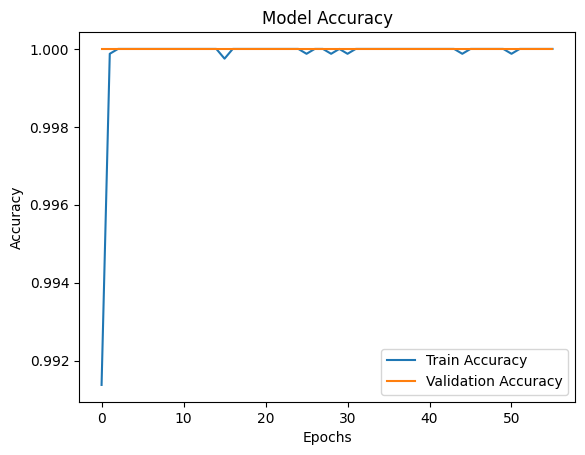

In [18]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
# from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

done


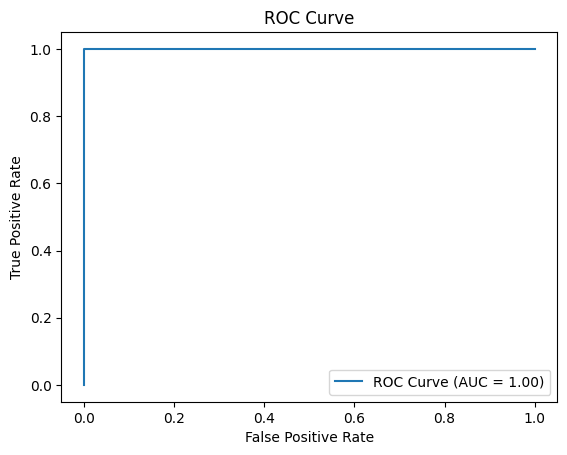

In [19]:

from sklearn.metrics import roc_curve, auc
y_pred=model.predict(X_test)
# If y_pred is shape (n_samples, 1), flatten it
if y_pred.ndim > 1:
	print('done')
	y_pred_flat = y_pred.ravel()
else:
	y_pred_flat = y_pred

# If y_pred contains hard labels, get probabilities if possible
# Here, we assume y_pred is already probabilities or binary labels
fpr, tpr, thresholds = roc_curve(y_test, y_pred_flat)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [ ]:
def clean_text(text):
    """
    Clean and preprocess text for consistent feature extraction.
    
    This function applies the same preprocessing steps used during training:
    - Tokenization and lowercasing
    - Stopword removal
    - Lemmatization
    - Alphabetic token filtering
    
    Args:
        text (str): Raw input text
        
    Returns:
        str: Cleaned and preprocessed text
    """
    # Tokenize and convert to lowercase
    tokens = word_tokenize(text.lower())
    
    # Filter and lemmatize tokens
    filtered_tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word.isalpha() and word not in stop_words
    ]
    
    return ' '.join(filtered_tokens)

In [24]:
# from sentence_transformers import SentenceTransformer
# from nltk.tokenize import sent_tokenize
# model_sent = SentenceTransformer('all-mpnet-base-v2')  # Fast & good for Colab
#test the model with a new sentence
new_sentence = "I hate you and hate everything about you, you petraed me"
new_sentence_cleaned = clean_text(new_sentence)
print(f"Cleaned new sentence: {new_sentence_cleaned}")

# Process the sentence with the same preprocessing as training
sentences = sent_tokenize(new_sentence_cleaned)
embeddings = model_sent.encode(sentences)
embeddings_mean = np.mean(embeddings, axis=0)  # Average the embeddings of sentences
embeddings_max = np.max(embeddings, axis=0)    # Max pooling of the embeddings
new_sentence_embedding = np.concatenate((embeddings_mean, embeddings_max))  # Concatenate mean and max
new_sentence_embedding = new_sentence_embedding.reshape(1, -1)  # Reshape for model input

new_prediction = model.predict(new_sentence_embedding)
new_prediction = (new_prediction > 0.5).astype(int)  # Convert to binary label
new_pred='negative' if new_prediction[0][0] == 1 else 'positive'
print(f"The predicted label for the new sentence is: {new_pred}")

Cleaned new sentence: hate hate everything petraed
The predicted label for the new sentence is: negative
